In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import q1_script

In [4]:
x_train = q1_script.read_pixels("data/train-images-idx3-ubyte.gz")
y_train = q1_script.read_labels("data/train-labels-idx1-ubyte.gz")

x_test = q1_script.read_pixels("data/t10k-images-idx3-ubyte.gz")
y_test = q1_script.read_labels("data/t10k-labels-idx1-ubyte.gz")

In [5]:
print(F"x_train shape: {x_train.shape}")
print(F"y_train shape: {y_train.shape}")
print(F"x_test shape: {x_test.shape}")
print(F"y_test shape: {y_test.shape}")

x_train shape: (60000, 784)
y_train shape: (60000,)
x_test shape: (10000, 784)
y_test shape: (10000,)


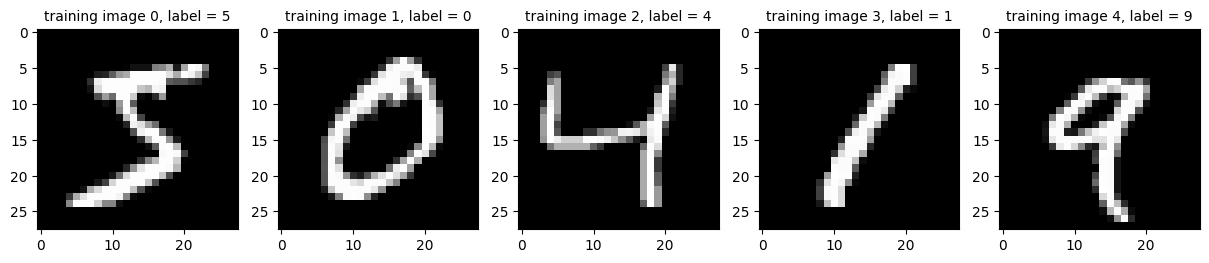

In [6]:
# reshaping the images from the training set back from 784x1 pixels to 28x28 pixels and displaying them with their labels and indexes
plt.figure(figsize=(15, 150))
for i in range(0, 5):
    plt.subplot(1, 5, i+1)
    img = x_train[i].reshape(28, 28)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title(f"training image {i}, label = {y_train[i]}", fontsize=10)
plt.show()

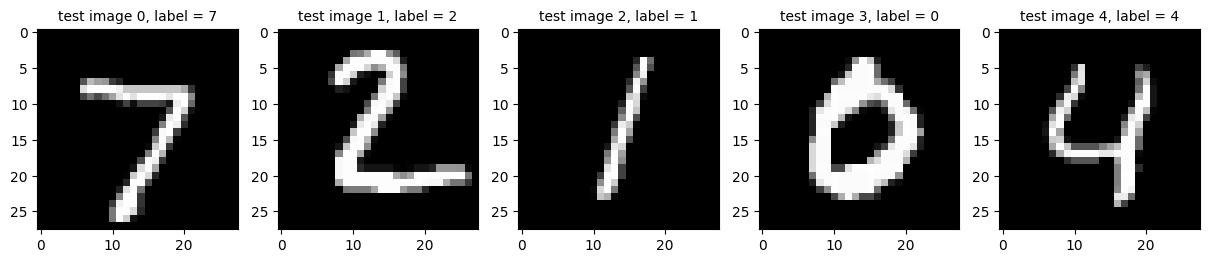

In [7]:
# reshaping the images from the test set back from 784x1 pixels to 28x28 pixels and displaying them with their labels and indexes
plt.figure(figsize=(15, 150))
for i in range(0, 5):
    plt.subplot(1, 5, i+1)
    img = x_test[i].reshape(28, 28)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title(f"test image {i}, label = {y_test[i]}", fontsize=10)
plt.show()

In [8]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (60000, 784)
y_train shape: (60000,)
x_test shape: (10000, 784)
y_test shape: (10000,)


In [9]:
mean_x_train = np.mean(x_train, axis=0)
x_train_cov_matrix = np.cov(x_train-mean_x_train,  rowvar=False)
print(f"covarience matrix shape: {x_train_cov_matrix.shape}")
train_eigenvalues, train_eigenvectors = np.linalg.eigh(x_train_cov_matrix)

covarience matrix shape: (784, 784)


In [10]:
print(f"train_eigenvalues shape: {train_eigenvalues.shape}")
print(f"train_eigenvectors shape: {train_eigenvectors.shape}")

train_eigenvalues shape: (784,)
train_eigenvectors shape: (784, 784)


In [11]:
order_of_importance = np.argsort(train_eigenvalues)[::-1]
train_eigenvalues = train_eigenvalues[order_of_importance]
train_eigenvectors = train_eigenvectors[:, order_of_importance]

train_pve = train_eigenvalues / np.sum(train_eigenvalues) # pve for each eigenvalue
train_cumulative_pve = np.cumsum(train_eigenvalues) / np.sum(train_eigenvalues) # cumulative sum of pve, it sums the pve of the eigenvalues from the first(smallest) one to the current one

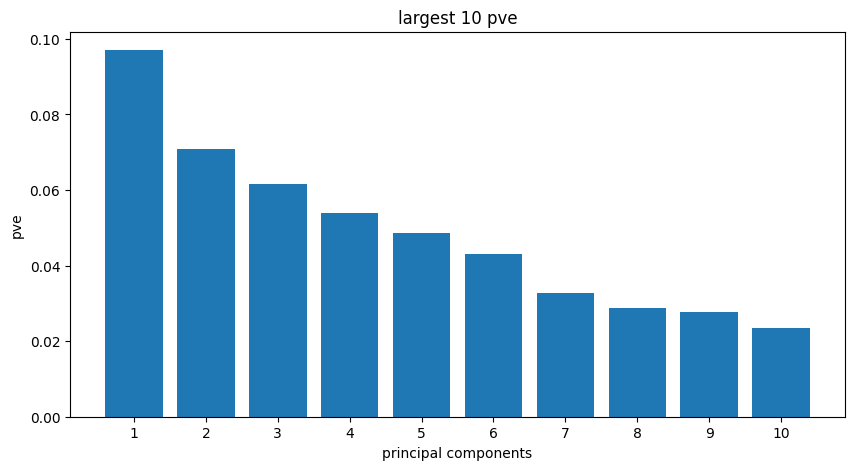

In [12]:
# plot the largest 10 pve as a bar chart
plt.figure(figsize=(10, 5))
plt.bar(np.arange(1, 11, 1), train_pve[:10])
plt.xticks(np.arange(1, 11, 1))
plt.xlabel("principal components")
plt.ylabel("pve")
plt.title("largest 10 pve")
plt.show()

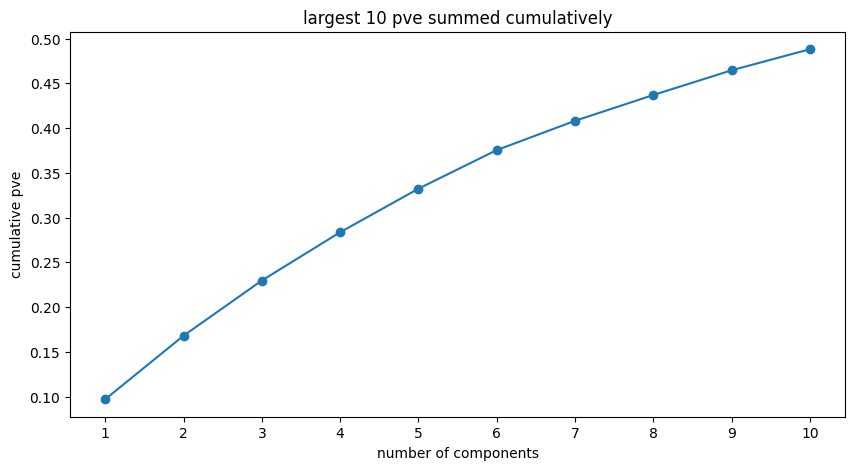

In [13]:
# plot the largest 10 pve cumulatively as a line chart
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 11, 1), train_cumulative_pve[:10], marker='o')
plt.xticks(np.arange(1, 11, 1))
plt.xlabel("number of components")
plt.ylabel("cumulative pve")
plt.title("largest 10 pve summed cumulatively")
plt.show()

In [14]:
# print where the pve is 70%
print(f"number of principal components that should be used to explain the 70% of the data: {np.argmax(train_cumulative_pve >= 0.7)}")

number of principal components that should be used to explain the 70% of the data: 25


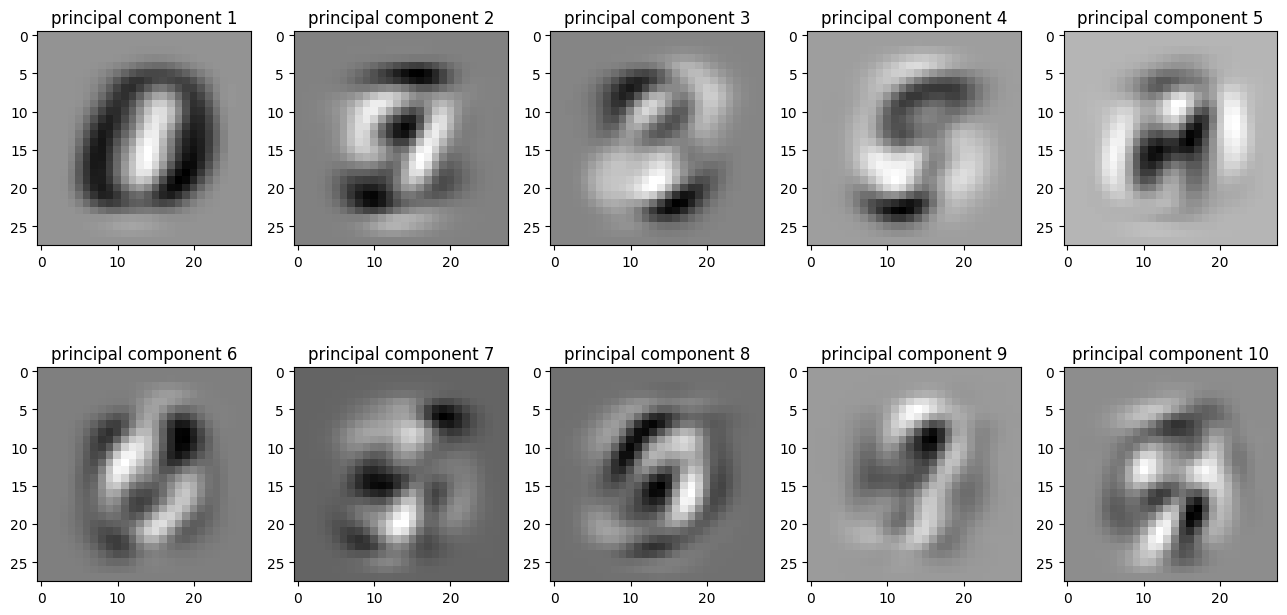

In [15]:
plt.figure(figsize=(16, 8))

for i in range(10):
    
    # min-max scale the first 10 eigenvectors
    eigenvector = train_eigenvectors[:, i]
    
    # Source: https://en.wikipedia.org/wiki/Feature_scaling
    eigenvector = (eigenvector - np.min(eigenvector)) / (np.max(eigenvector) - np.min(eigenvector))
    
    # reshape the eigenvector from 784x1 to 28x28 to be able to display it as an image
    eigenvector = eigenvector.reshape(28, 28)

    
    # display the results
    plt.subplot(2, 5, i+1)
    plt.imshow(eigenvector, cmap=plt.cm.gray)
    plt.title(f"principal component {i+1}")
    
plt.show()

In [16]:
train_eigenvectors[0].shape

(784,)

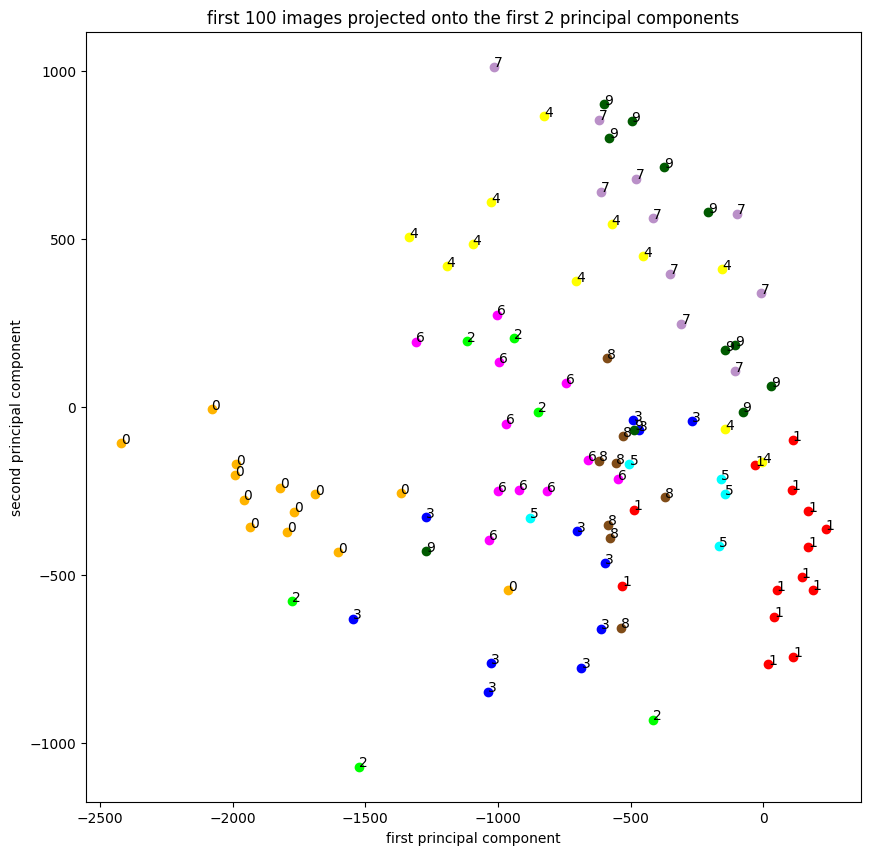

In [17]:
# project the training data onto the first 10 principal components

# color map for the labels
label_colors = np.array([[255, 180, 0], [255, 0, 0], [0, 255, 0], [0, 0, 255],
                         [255, 255, 0], [0, 255, 255], [255, 0, 255],
                         [186, 144, 200], [128, 76, 24], [0, 90, 0]])

label_colors = label_colors / 255

# project the first 100 images in the training set onto the first 2 principal components
plt.figure(figsize=(10, 10))
for i in range(100):
       
    # project the image onto the first principal component
    projected_image_1 = np.dot(x_train[i], train_eigenvectors[:, 0])    # train_eigenvectors are already in order of importance
    
    # project the image onto the second principal component
    projected_image_2 = np.dot(x_train[i], train_eigenvectors[:, 1])
    
    # plot the projected images with their labels and with colors based on their labels
    plt.scatter(projected_image_1, projected_image_2, color=label_colors[y_train[i]])
    plt.annotate(y_train[i], (projected_image_1, projected_image_2))

plt.xlabel("first principal component")
plt.ylabel("second principal component")
plt.title("first 100 images projected onto the first 2 principal components")
plt.show()


In [18]:
def reconstruct_image(original_image, k):
    # reconstruct the original image using k principal components
    reconstructed_image = np.dot(np.dot(original_image, train_eigenvectors[:, :k]), train_eigenvectors[:, :k].T)
    return reconstructed_image


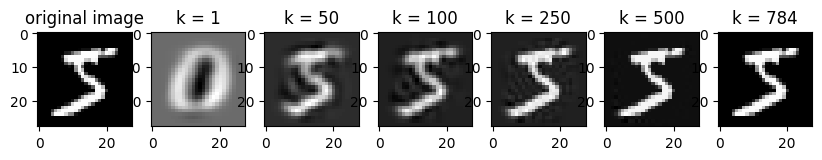

In [19]:
# reconstruct an original digit image using k principal components
# choose k from 1, 50, 100, 250, 500, 784 and display the results as columns

original_image = x_train[0]

# display the original image
plt.figure(figsize=(10, 10))
plt.subplot(1, 7, 1)
plt.imshow(original_image.reshape(28, 28), cmap=plt.cm.gray)
plt.title("original image")

for i, k in enumerate([1, 50, 100, 250, 500, 784]):
    
    # reconstruct the image using k principal components
    reconstructed_image = reconstruct_image(original_image, k)
    
    # reshape the reconstructed image from 784x1 to 28x28 to be able to display it as an image
    reconstructed_image = reconstructed_image.reshape(28, 28)
    
    # display the results
    plt.subplot(1, 7, i+2)
    plt.imshow(reconstructed_image, cmap=plt.cm.gray)
    plt.title(f"k = {k}")